In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm, norm
import scipy.integrate as integrate
from time import sleep

import warnings
warnings.filterwarnings('ignore')

## General utils

In [2]:
def gamma_density(x, alpha, beta):
    return gamma.pdf(x, a=alpha, scale=1/beta)

def lognormal_cdf(x, mu, sigma):
    return norm.cdf((np.log(x) - mu)/sigma)

def plot_functions(fs, x_min, x_max, step):
    x_values = np.arange(x_min, x_max, step)
    for i, f in enumerate(fs):
        plt.plot(x_values, [f(x) for x in x_values], label=str(i))
    plt.legend()
    plt.show()

@dataclass
class DeltaMeasure:
    position: float
    height: float


def convolve(f1, f2, x_min, x_max, step):
    if isinstance(f2, DeltaMeasure):
        return lambda x: f2.height * f1(x - f2.position)
    raise ValueError("Not implemented yet")  # TODO: add
#     x_values = np.arange(x_min, x_max, step)
#     f1_samples = [f1(x) for x in x_values]
#     f2_samples = [f2(x) for x in x_values]
#     g_samples = np.convolve(f1_samples, f2_samples, mode='same') * step
    
#     print(f1_samples)
#     print(g_samples)
    
#     def g(x):
#         if x_min < x < x_max:
#             return np.interp(x, x_values, g_samples)
#         else:
#             return 0
#     return g

def list_from_f(f, x_min, x_max, step):
    x_values = np.arange(x_min, x_max + step, step )
    return [f(x) for x in x_values]

def f_from_list(f_values, x_min, x_max, step):
    
    def f(x):
        if x < x_min:
            return f_values[0]
        if x> x_max:
            return f_values[-1]
        i = int((x-x_min)/step)
        return f_values[i]
    
    return f

Example of convolution

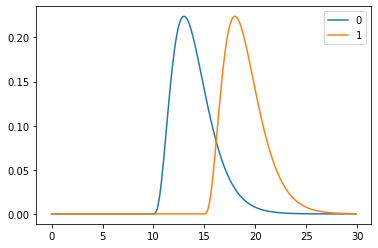

In [3]:
f1 = lambda x: gamma_density(x-10, 4, 1)
# f2= lambda x: gamma_density(x-10, 20, 20)
f2 = DeltaMeasure(position=5, height=1)

g = convolve(f1, f2, 0, 30, 1)
plot_functions([f1, g], 0, 30, 0.1)
# plot_function(g, 0, 30, 0.1)

# Setting up the parameters

Parameters for numerical computations:

In [4]:
# Maximum tau for integrals in the relative time:
tau_max = 30
# Step for integrals and convolutions
step = 0.03

## Reproduction number (no contact tracing)

$$R^0_t = \int_{[0,+\infty)}r^0_t(\tau)\mathrm{d}\tau $$

Below, $r^0_t$ is modeled with a gamma distribution, whose parameters $\alpha$ and $\beta$ are taken from [this sheet](https://docs.google.com/spreadsheets/d/1rJeG96_4ODDyM7CIfIYahTxOsx6FDRFuig-To0y_g5I/edit#gid=755170273).
The dependency on the absolute time is simply realized through a global scale factor $\psi_t$:
$$r^0_t = r^0_0\psi_t$$

The function r^0_0:


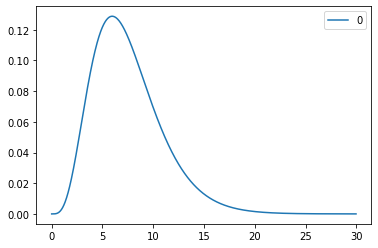

Integral of r^0_0: 0.9999787246061232


In [5]:
R0_0 = 1
alpha=4.865916955
beta=0.6487889273

def r0_0(tau):
    return R0_0 * gamma_density(tau, alpha, beta)

print("The function r^0_0:")
plot_functions([r0_0], x_min=0, x_max=tau_max, step=step)

print("Integral of r^0_0:", integrate.quad(r0_0, 0, 30)[0])  # Should give back R0

def psi(t):
    return 1

def R0(t):
    return R0_0 * psi(t)

def r0(t, tau):
    return R0(t) * r0_0(tau)

## Incubation period distribution

With $\tau^S$ we denote the random variable describing the time of appearance of symptoms of an infected person. $F^S$ denotes its CDF.

The model used here of $\tau^S$ as a lognormally distributed variable is taken from [Ferretti et al.](https://science.sciencemag.org/content/early/2020/04/09/science.abb6936), table 1.

The CDF of tau^S:


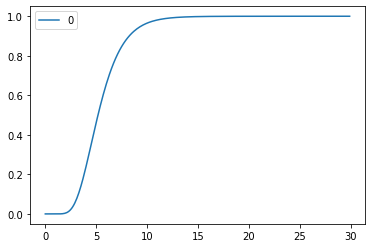

In [6]:
# Incubation period distribution
    
# See [1], table 1
mu = 1.644
sigma = 0.363

def FS(tau):
    if tau>0:
        return lognormal_cdf(tau, mu, sigma)
    else:
        return 0

print("The CDF of tau^S:")
plot_functions([FS], x_min=0, x_max=tau_max, step=step)

## Action times distributions

$\tau^{A,s}$: time of action induced by symptoms  
$\tau^{A,c}_t$: time of action induced by knowledge of a positive contact, for an individual infected at absolute time $t$.  
$\tau^A_t=\min(\tau^{A,s}, \tau^{A,c}_t)$: time of any action


Note that the definition of $\tau^A_t$ implies
$$F^A_t(\tau) = F^{A,s}(\tau) + F^{A,c}_t(\tau) - F^{A,s}_t(\tau)F^{A,c}_t(\tau).$$

In [7]:
sS = 1. # Probability of (immediate) CTA given symptoms

def FAs(tau):
    return sS * FS(tau)

The CDF of tau^{A,s}:


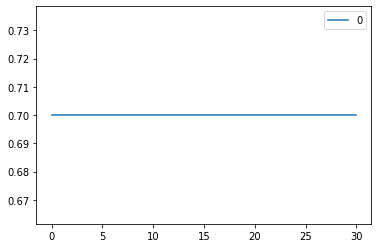

In [8]:
print("The CDF of tau^{A,s}:")
plot_functions([FAs], x_min=0, x_max=tau_max, step=step)

# Corrected reproduction number

NB: for simplicity we ignore, in the absolute time dependency, the suppression of $R$ due to the reduction in the number of susceptible induviduals, as this happens on a larger time scale that the one considered here.

1) Estimating $r^\text{corr}$ from the knowledge of $\tau^T$

$$r_t(\tau) = (1-\xi\,F^T_t(\tau))r^0_t(\tau)$$

$\xi$=probability that an individual tested positive self-isolates

In [11]:
# Corrected reproduction number

def make_r_t_from_test_cdf(r0_t, F_T, xi):
    return lambda tau: r0_t(tau)*(1 - F_T(tau) * xi)

def make_r_from_test_cdf(r0, F_T, xi):
    return lambda t, tau: r0(t, tau)*(1 - F_T(t, tau) * xi)



**Example:** constant testing time $\tau^\text{T}$ peaked at $\tau=10$

Plot of r0 and r_corr:


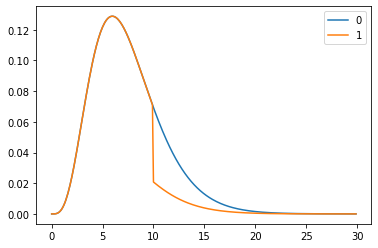

R_0 = 0.8546348985819439


In [10]:
tau_s = 10
F_Tsimple = lambda tau: np.heaviside(tau - tau_s, 1)
xi = 0.7  # Probability of (immediate) isolation given positive test

r_0 = make_r_t_from_test_cdf(r0_0, F_Tsimple, xi)

print("Plot of r0 and r_corr:")
plot_functions([r0_0, r_0], x_min=0, x_max=tau_max, step=step)

R_0 = integrate.quad(lambda tau: r_0(tau), 0, tau_max)[0]
print("R_0 =",R_0)

2) Estimating $r_t$ from the knowledge of $\tau^{A,s}$, $\tau^{A,c}_t$ and $\Delta^{A\to T}$.

Here $\Delta^{A\to T}$ is the time taken for an infected individual from the instant of action to the instanct of positive testing, i.e.
$$\tau^T_t = \tau^A_t + \Delta^{A\to T}$$
and hence
$$F^T_t(\tau) = \int_{[0,+\infty)}F^A_t(\tau')p_{\Delta^{A\to T}}(\tau-\tau')\mathrm{d}\tau'.$$

**Example:** $p_{\Delta^{A\to T}}$ concentrated in a point $\Delta t_\text{test}$

In [11]:
Deltat_test = 1
p_DeltaAT = DeltaMeasure(position=Deltat_test, height=1)

# height = 2
# p_DeltaAT = lambda sigma: height * (np.heaviside(sigma - position, 1) - np.heaviside(sigma - (position + 1/height), 1))

# plot_function(p_DeltaAT, x_min=0, x_max=30, step=0.1)
# print(integrate.quad(p_DeltaAT, 0, 30)[0])

## Evolution of $R_t$ in the homogeneous model

$$s^\text{C}_tF^\text{T}_t(\tau) \simeq F^\text{A,c}_{t+\mathbb{E}(\tau^\text{C}_t)}(\tau - \mathbb{E}(\tau^\text{C}_t))$$

In [12]:
#   INPUTS    #
sS = 1. # Probability of (immediate) CTA given symptoms
sC = 0.
xi = 1.

Deltat_test = 0

# The original reproduction number:
R0_0 = 1
alpha=4.865916955  # parameters of the gamma distrbution
beta=0.6487889273

# The incubation period distribution
mu = 1.644
sigma = 0.363

In [ ]:
# %matplotlib notebook

def r0_0(tau):
    return R0_0 * gamma_density(tau, alpha, beta)

def psi(t):
    return 1

def R0(t):
    return R0_0 * psi(t)

def r0(t, tau):
    return R0(t) * r0_0(tau)

def FS(tau, normalization=1.):
    if tau>0:
        return normalization*lognormal_cdf(tau, mu, sigma)
    else:
        return 0

def FAs(tau):
    return sS * FS(tau)


p_DeltaAT = DeltaMeasure(position=Deltat_test, height=1)


##### Iterations 

N_iterations = 6


# FA_list = []
t_list = []
pC_list = []
FT_list = []
FTinfty_list = []
R_list = []

fig = plt.figure(figsize=(10,15))

r_tplot = fig.add_subplot(311)
r_tplot.set_xlabel('tau [days]')
r_tplot.set_ylabel('r_t')
r_tplot.grid(True)
r_tplot.set_xlim(0,tau_max)
r_tplot.set_ylim(0,R0_0/6)

tau_values = np.arange(0, tau_max + step, step)

for i in range(0, N_iterations):
    
    if i == 0:
        t = 0
        FA_t = FAs
        
    else:
        
        FT_prev_values = FT_list[-1]
        FT_prev = f_from_list(FT_prev_values, 0, tau_max, step)
        pC_prev_values = pC_list[-1]
        pC_prev = f_from_list(pC_prev_values, 0, tau_max, step)
        
#         tauC_exp = integrate.quad(lambda tau: 1 - FC_prev(tau), 0, tau_max)[0]
        tauC_exp = integrate.quad(lambda tau: tau * pC_prev(tau), 0, tau_max)[0]
        t = t_list[-1] + tauC_exp
        FAc_t = lambda tau: sC * FT_prev(tau + tauC_exp)  # Time evolution formula here
        FA_t = lambda tau: FAs(tau) + FAc_t(tau) - FAs(tau) * FAc_t(tau)
        
    FT_t = convolve(FA_t, p_DeltaAT, 0, tau_max, step)
    FT_t_infty = FT_t(tau_max)
    r_t = make_r_t_from_test_cdf(lambda tau: r0(t, tau), FT_t, xi)
    R_t = integrate.quad(r_t, 0, tau_max)[0]
    pC_t = lambda tau: r_t(tau)/R_t
    
    t_list.append(t)
    r_t_values = list_from_f(r_t, 0, tau_max, step)
    pC_t_values = list_from_f(pC_t, 0, tau_max, step)
    FT_t_values = list_from_f(FT_t, 0, tau_max, step)
    pC_list.append(pC_t_values) 
    FT_list.append(FT_t_values) 
    FTinfty_list.append(FT_t_infty)
    R_list.append(R_t)
    
    print(f"t={round(t, 1)}")
    if i>0:
        print(
              f"    FAs(infty)={FAs(tau_max)}  "
              f"FAc_t(infty)={FAc_t(tau_max)}  "
        )
    print(f"    FA_t(infty)={FA_t(tau_max)} \n"
          f"    FT_t(infty)={round(FT_t_infty, 2)}, \n"
          f"    R_t={round(R_t, 2)}")
    
    
    r_tplot.plot(tau_values, r_t_values, "r")

    fig.canvas.draw()
    
#     sleep(0.1)
    
R_tplot = fig.add_subplot(312)
R_tplot.set_xlabel('t [days]')
R_tplot.set_ylabel('R_t')
R_tplot.grid(True)
R_tplot.set_xlim(0,t_list[-1])
R_tplot.set_ylim(0,R0_0)
R_tplot.plot(t_list, R_list, "r")



FTinftyplot = fig.add_subplot(313)
FTinftyplot.set_xlabel('t [days]')
FTinftyplot.set_ylabel('FT_t(infty)')
FTinftyplot.grid(True)
FTinftyplot.set_xlim(0,t_list[-1])
FTinftyplot.set_ylim(0,1)
FTinftyplot.plot(t_list, FTinfty_list, "r")

t=0
    FA_t(infty)=0.95 
    FT_t(infty)=0.95, 
    R_t=0.05
t=7.5
    FAs(infty)=0.95  FAc_t(infty)=0.0  
    FA_t(infty)=0.95 
    FT_t(infty)=0.95, 
    R_t=0.05
t=15.0
    FAs(infty)=0.95  FAc_t(infty)=0.0  
    FA_t(infty)=0.95 
    FT_t(infty)=0.95, 
    R_t=0.05
t=22.5
    FAs(infty)=0.95  FAc_t(infty)=0.0  
    FA_t(infty)=0.95 
    FT_t(infty)=0.95, 
    R_t=0.05
t=30.1
    FAs(infty)=0.95  FAc_t(infty)=0.0  
    FA_t(infty)=0.95 
    FT_t(infty)=0.95, 
    R_t=0.05


## Evolution of $R_t$ in the two-components model

$$ \begin{array}{rcl}
P_t\,s^\text{C,app}_t F^\text{T,app}_t(\tau) + (1-P_t)\,s^\text{C, no app}_t F^\text{T,no app}_t(\tau) &\simeq&  F^\text{A,c,app}_{t+\mathbb{E}(\tilde\tau^\text{C}_t)}(\tau - \mathbb{E}(\tilde\tau^\text{C}_t))\,,\\
P_t\,s^\text{C,no app}_t F^\text{T,app}_t(\tau) + (1-P_t)\,s^\text{C, no app}_t F^\text{T,no app}_t(\tau) &\simeq&  F^\text{A,c,no app}_{t+\mathbb{E}(\tilde\tau^\text{C}_t)}(\tau - \mathbb{E}(\tilde\tau^\text{C}_t))\,.
\end{array}$$

In [25]:
#   INPUTS    #
sSapp = 0.4 # Probability of (immediate) CTA given symptoms
sSnoapp = 0.2
sCapp = 0.6
sCnoapp = 0.2
xi = 0.8

def epsilon(t):
    if t<=10:
        return 0
    else:
        return 0.6

Deltat_testapp = 2
Deltat_testnoapp = 4

# The original reproduction number:
R0_0 = 1
alpha=4.865916955  # parameters of the gamma distrbution
beta=0.6487889273

# The incubation period distribution
mu = 1.644
sigma = 0.363



t=0, 
    FTapp_t(infty)=0.4,  FTnoapp_t(infty)=0.2,  FT_t(infty)=0.2, 
    epsilon_t=0,  P_t=0.0    R_t=0.96    E(tauC)=7.32
t=7.4, 
    FTapp_t(infty)=0.42,  FTnoapp_t(infty)=0.23,  FT_t(infty)=0.23, 
    epsilon_t=0,  P_t=0.0    R_t=0.94    E(tauC)=7.29
t=14.7, 
    FTapp_t(infty)=0.43,  FTnoapp_t(infty)=0.24,  FT_t(infty)=0.35, 
    epsilon_t=0.6,  P_t=0.57    R_t=0.87    E(tauC)=7.15
t=21.9, 
    FTapp_t(infty)=0.5,  FTnoapp_t(infty)=0.26,  FT_t(infty)=0.4, 
    epsilon_t=0.6,  P_t=0.55    R_t=0.82    E(tauC)=7.15
t=29.1, 
    FTapp_t(infty)=0.51,  FTnoapp_t(infty)=0.26,  FT_t(infty)=0.41, 
    epsilon_t=0.6,  P_t=0.55    R_t=0.81    E(tauC)=7.15
t=36.3, 
    FTapp_t(infty)=0.52,  FTnoapp_t(infty)=0.26,  FT_t(infty)=0.41, 
    epsilon_t=0.6,  P_t=0.55    R_t=0.8    E(tauC)=7.16


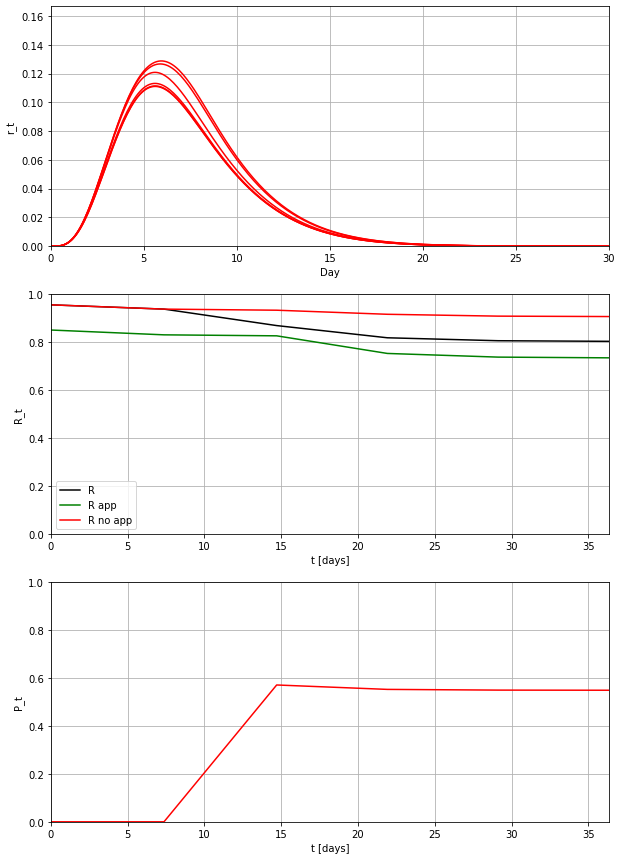

In [27]:
# %matplotlib notebook

def r0_0(tau):
    return R0_0 * gamma_density(tau, alpha, beta)

def psi(t):
    return 1

def R0(t):
    return R0_0 * psi(t)

def r0(t, tau):
    return R0(t) * r0_0(tau)

def FS(tau):
    if tau>0:
        return lognormal_cdf(tau, mu, sigma)
    else:
        return 0

def FAsapp(tau):
    return sSapp * FS(tau)

def FAsnoapp(tau):
    return sSnoapp * FS(tau)


p_DeltaATapp = DeltaMeasure(position=Deltat_testapp, height=1)
p_DeltaATnoapp = DeltaMeasure(position=Deltat_testnoapp, height=1)




##### Iterations 

N_iterations = 6


# FA_list = []
t_list = []
tildepC_list = []
FTapp_list = []
FTnoapp_list = []
FTinftyapp_list = []
FTinftynoapp_list = []
FTinfty_list = []
R_list = []
Rapp_list = []
Rnoapp_list = []
P_list = []
tauC_exp_list = []

fig = plt.figure(figsize=(10,15))

r_tplot = fig.add_subplot(311)
r_tplot.set_xlabel('Day')
r_tplot.set_ylabel('r_t')
r_tplot.grid(True)
r_tplot.set_xlim(0,tau_max)
r_tplot.set_ylim(0,R0_0/6)

tau_values = np.arange(0, tau_max + step, step)


for i in range(0, N_iterations):
    
    if i == 0:
        t = 0
        FAapp_t = FAsapp
        FAnoapp_t = FAsnoapp
        
    else:
        
        FTapp_prev_values = FTapp_list[-1]
        FTapp_prev = f_from_list(FTapp_prev_values, 0, tau_max, step)
        FTnoapp_prev_values = FTnoapp_list[-1]
        FTnoapp_prev = f_from_list(FTnoapp_prev_values, 0, tau_max, step)
        tildepC_prev_values = tildepC_list[-1]
        tildepC_prev = f_from_list(tildepC_prev_values, 0, tau_max, step)
        

        tildetauC_exp = integrate.quad(lambda tau: tau * tildepC_prev(tau), 0, tau_max)[0]
        t = t_list[-1] + tildetauC_exp
        
        P_prev = P_list[-1]
        
        # Evolution equations here:
        LHSapp = lambda tau: sCapp * P_prev * FTapp_prev(tau) + (1 - P_prev) * sCnoapp * FTnoapp_prev(tau)
        FAcapp_t = lambda tau: LHSapp(tau + tildetauC_exp)
        FAapp_t = lambda tau: FAsapp(tau) + FAcapp_t(tau) - FAsapp(tau) * FAcapp_t(tau)
        
        LHSnoapp = lambda tau: sCnoapp * P_prev * FTapp_prev(tau) + (1 - P_prev) * sCnoapp * FTnoapp_prev(tau)
        FAcnoapp_t = lambda tau: LHSnoapp(tau + tildetauC_exp)
        FAnoapp_t = lambda tau: FAsnoapp(tau) + FAcnoapp_t(tau) - FAsnoapp(tau) * FAcnoapp_t(tau)
        
    FTapp_t = convolve(FAapp_t, p_DeltaATapp, 0, tau_max, step)
    rapp_t = make_r_t_from_test_cdf(lambda tau: r0(t, tau), FTapp_t, xi)
    
    FTnoapp_t = convolve(FAnoapp_t, p_DeltaATnoapp, 0, tau_max, step)
    rnoapp_t = make_r_t_from_test_cdf(lambda tau: r0(t, tau), FTnoapp_t, xi)
    
    r_t = lambda tau: epsilon(t) * rapp_t(tau) + (1-epsilon(t)) * rnoapp_t(tau)

    Rapp_t = integrate.quad(rapp_t, 0, tau_max)[0]
    Rnoapp_t = integrate.quad(rnoapp_t, 0, tau_max)[0]
    R_t = integrate.quad(r_t, 0, tau_max)[0]
    
    tauC_exp = integrate.quad(lambda tau: tau * r_t(tau)/R_t, 0, tau_max)[0]
    
    P_t = epsilon(t) * Rapp_t / R_t
    
    tilder_t = lambda tau : P_t * rapp_t(tau) + (1-P_t) * rnoapp_t(tau)
    tildeR_t = integrate.quad(tilder_t, 0, tau_max)[0]
    tildepC_t = lambda tau: tilder_t(tau)/tildeR_t

    FTinftyapp = FTapp_t(tau_max)
    FTinftynoapp = FTnoapp_t(tau_max)
    FTinfty = epsilon(t) * FTinftyapp + (1-epsilon(t)) * FTinftynoapp
    
    t_list.append(t)
    r_t_values = list_from_f(r_t, 0, tau_max, step)
    tildepC_t_values = list_from_f(tildepC_t, 0, tau_max, step)
    FTapp_t_values = list_from_f(FTapp_t, 0, tau_max, step)
    FTnoapp_t_values = list_from_f(FTnoapp_t, 0, tau_max, step)
    tildepC_list.append(tildepC_t_values) 
    FTapp_list.append(FTapp_t_values) 
    FTnoapp_list.append(FTnoapp_t_values)
    FTinftyapp_list.append(FTinftyapp)
    FTinftynoapp_list.append(FTinftynoapp)
    FTinfty_list.append(FTinfty)
    R_list.append(R_t)
    Rapp_list.append(Rapp_t)
    Rnoapp_list.append(Rnoapp_t)
    P_list.append(P_t)
    tauC_exp_list.append(tauC_exp)
    
    print(f"t={round(t, 1)}, \n"
          f"    FTapp_t(infty)={round(FTinftyapp, 2)},  FTnoapp_t(infty)={round(FTinftynoapp, 2)},  FT_t(infty)={round(FTinfty, 2)}, \n"
          f"    epsilon_t={epsilon(t)},  P_t={round(P_t, 2)}"
          f"    R_t={round(R_t, 2)}"
          f"    E(tauC)={round(tauC_exp, 2)}"
         )

    r_tplot.plot(tau_values, r_t_values, "r")

    fig.canvas.draw()
      
R_tplot = fig.add_subplot(312)
R_tplot.set_xlabel('t [days]')
R_tplot.set_ylabel('R_t')
R_tplot.grid(True)
R_tplot.set_xlim(0,t_list[-1])
R_tplot.set_ylim(0,R0_0)
R_tplot.plot(t_list, R_list, color="black",  label="R")
R_tplot.plot(t_list, Rapp_list, color="green", label="R app")
R_tplot.plot(t_list, Rnoapp_list, color="red", label="R no app")
R_tplot.legend()


Pplot = fig.add_subplot(313)
Pplot.set_xlabel('t [days]')
Pplot.set_ylabel('P_t')
Pplot.grid(True)
Pplot.set_xlim(0,t_list[-1])
Pplot.set_ylim(0,1)
Pplot.plot(t_list, P_list, "r")